In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import RocCurveDisplay

## Time Series Tasks

1. Convert the longitudinal blood pressure measurements into a proper time series:
   - Create a pandas Series with DatetimeIndex using `visit_date`
   - Handle any missing or duplicate measurements appropriately
   - Tips: 
     - Use `pd.to_datetime()` with format='%Y-%m-%d' for reliable parsing
     - Handle duplicates with `duplicated()` and appropriate aggregation
     - Consider timezone handling with `tz_localize()` if needed
     - Use `interpolate()` or `fillna()` for missing values

In [2]:
# Load the data
patient_baseline = pd.read_csv('patient_baseline.csv', sep='\t')
patient_longitudinal = pd.read_csv('patient_longitudinal.csv', sep='\t')
patient_treatment = pd.read_csv('patient_treatment.csv', sep='\t')

In [3]:
patient_baseline.head(3)

,patient_id,age,sex,bmi,smoking,diabetes,bp_systolic,cholesterol,heart_rate
0,0,57.5,0,25.8,0,0,108.7,257.9,79.3
1,1,47.9,0,23.2,0,0,149.4,155.9,75.4
2,2,59.7,1,29.0,0,0,136.7,220.7,85.0


In [4]:
patient_longitudinal.head(3)

,patient_id,visit_date,bp_systolic,heart_rate,adverse_event,age,sex,bmi,smoking,diabetes
0,0,2023-01-17,108.6,72.4,0,57.5,0.0,25.8,0.0,0.0
1,0,2023-02-22,104.8,71.9,0,57.5,0.0,25.8,0.0,0.0
2,0,2023-03-23,106.3,76.2,0,57.5,0.0,25.8,0.0,0.0


In [5]:
patient_treatment.head(3)

,patient_id,age,sex,bmi,smoking,diabetes,bp_systolic,cholesterol,heart_rate,treatment,adherence,outcome
0,0,57.5,0,25.8,0,0,108.7,257.9,79.3,0,0.81,0
1,1,47.9,0,23.2,0,0,149.4,155.9,75.4,1,0.91,1
2,2,59.7,1,29.0,0,0,136.7,220.7,85.0,1,0.73,1


According to `generate_health_data.py`, the values for `age`, `sex`, `bmi`, `smoking`, and `diabetes` are consistent across all three tables. These duplicated columns will be dropped for better readability.

In [6]:
drop_col = ['age', 'sex', 'bmi', 'smoking', 'diabetes']
patient_longitudinal.drop(drop_col, axis=1,inplace=True)
patient_treatment.drop(drop_col, axis=1,inplace=True)

According to `generate_health_data.py`, the values for `bp_systolic`,`cholesterol`,	and `heart_rate` are consistent across baseline and treatment tables. These duplicated columns will be dropped for better readability.

In [7]:
drop_col = ['bp_systolic','cholesterol','heart_rate']
patient_treatment.drop(drop_col, axis=1,inplace=True)

In [8]:
# Comibine the datasets on patient_id
combined_df = pd.merge(patient_baseline, patient_longitudinal, on='patient_id', suffixes=('_baseline', '_longitudinal'))

In [9]:
df = pd.merge(combined_df, patient_treatment, on='patient_id', suffixes=('', 'treatment'))

In [10]:
df

,patient_id,age,sex,bmi,smoking,diabetes,bp_systolic_baseline,cholesterol,heart_rate_baseline,visit_date,bp_systolic_longitudinal,heart_rate_longitudinal,adverse_event,treatment,adherence,outcome
0,0,57.5,0,25.8,0,0,108.7,257.9,79.3,2023-01-17,108.6,72.4,0,0,0.81,0
1,0,57.5,0,25.8,0,0,108.7,257.9,79.3,2023-02-22,104.8,71.9,0,0,0.81,0
2,0,57.5,0,25.8,0,0,108.7,257.9,79.3,2023-03-23,106.3,76.2,0,0,0.81,0
3,0,57.5,0,25.8,0,0,108.7,257.9,79.3,2023-04-16,110.8,76.5,0,0,0.81,0
4,0,57.5,0,25.8,0,0,108.7,257.9,79.3,2023-06-05,117.7,78.4,0,0,0.81,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60995,999,58.6,0,25.6,0,0,140.1,228.9,95.6,2027-09-17,136.4,91.5,0,1,0.73,1
60996,999,58.6,0,25.6,0,0,140.1,228.9,95.6,2027-08-28,138.4,95.0,0,1,0.73,1
60997,999,58.6,0,25.6,0,0,140.1,228.9,95.6,2027-10-14,137.6,94.0,0,1,0.73,1
60998,999,58.6,0,25.6,0,0,140.1,228.9,95.6,2027-12-11,135.1,91.9,0,1,0.73,1


In [11]:
# Convert visit_date column to datetime format
df['visit_date'] = pd.to_datetime(df['visit_date'],format='%Y-%m-%d')

There is no need to set the timezone because the visit date data does not include time.

In [12]:
# Check the duplicated record
df.duplicated(['patient_id', 'visit_date']).sum()

np.int64(1000)

There is no duplicated record.

In [13]:
# Check the missing value
df.isnull().sum()

patient_id                  0
age                         0
sex                         0
bmi                         0
smoking                     0
diabetes                    0
bp_systolic_baseline        0
cholesterol                 0
heart_rate_baseline         0
visit_date                  0
bp_systolic_longitudinal    0
heart_rate_longitudinal     0
adverse_event               0
treatment                   0
adherence                   0
outcome                     0
dtype: int64

There is no missing value.

2. Analyze blood pressure trends:
   - Resample the data to monthly frequency using mean aggregation
   - Calculate 3-month moving averages to smooth out short-term fluctuations
   - Visualize both the original and smoothed trends
   - Tips:
     - Use `resample('ME').mean()` for month-end frequency
     - Add `min_periods` to `rolling()` to handle edge cases
     - Consider `interpolate()` method for gaps
     - Use `ewm()` for exponential weighted alternatives

In [14]:
# Set `visit_date` as the index
df.set_index('visit_date', inplace=True)

In [15]:
# Calculate the month-end frequency
monthly_bp = df['bp_systolic_longitudinal'].resample('M').mean()

C:\Users\ykatsuhara\AppData\Local\Temp\ipykernel_17776\690360529.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_bp = df['bp_systolic_longitudinal'].resample('M').mean()


In [16]:
monthly_bp

visit_date
2023-01-31    134.445300
2023-02-28    134.481200
2023-03-31    134.387900
2023-04-30    134.578400
2023-05-31           NaN
2023-06-30    134.518233
2023-07-31    134.455300
2023-08-31    134.499100
2023-09-30           NaN
2023-10-31    134.591850
2023-11-30           NaN
2023-12-31    134.632900
2024-01-31    134.689500
2024-02-29           NaN
2024-03-31    134.697800
2024-04-30    134.656400
2024-05-31    134.815850
2024-06-30           NaN
2024-07-31    134.846900
2024-08-31           NaN
2024-09-30           NaN
2024-10-31    134.772950
2024-11-30    134.747400
2024-12-31    134.652300
2025-01-31    134.777600
2025-02-28    134.569950
2025-03-31    134.602700
2025-04-30    134.450300
2025-05-31           NaN
2025-06-30    134.296100
2025-07-31    134.470200
2025-08-31    134.325400
2025-09-30           NaN
2025-10-31           NaN
2025-11-30    134.381300
2025-12-31    134.355400
2026-01-31    134.348700
2026-02-28    134.314300
2026-03-31           NaN
2026-04-30    

In [17]:
# Impute the gap using linear model
monthly_bp = monthly_bp.interpolate(method='linear')

In [18]:
monthly_bp

visit_date
2023-01-31    134.445300
2023-02-28    134.481200
2023-03-31    134.387900
2023-04-30    134.578400
2023-05-31    134.548317
2023-06-30    134.518233
2023-07-31    134.455300
2023-08-31    134.499100
2023-09-30    134.545475
2023-10-31    134.591850
2023-11-30    134.612375
2023-12-31    134.632900
2024-01-31    134.689500
2024-02-29    134.693650
2024-03-31    134.697800
2024-04-30    134.656400
2024-05-31    134.815850
2024-06-30    134.831375
2024-07-31    134.846900
2024-08-31    134.822250
2024-09-30    134.797600
2024-10-31    134.772950
2024-11-30    134.747400
2024-12-31    134.652300
2025-01-31    134.777600
2025-02-28    134.569950
2025-03-31    134.602700
2025-04-30    134.450300
2025-05-31    134.373200
2025-06-30    134.296100
2025-07-31    134.470200
2025-08-31    134.325400
2025-09-30    134.344033
2025-10-31    134.362667
2025-11-30    134.381300
2025-12-31    134.355400
2026-01-31    134.348700
2026-02-28    134.314300
2026-03-31    134.445400
2026-04-30    

In [19]:
# Calculate 3-month moving averages
monthly_bp_smooth = monthly_bp.rolling(window=3, min_periods=1).mean() # To handle the edge case, min_periods is set to 1

In [20]:
# Calculate exponential weighted statistics
monthly_bp_ewm = monthly_bp.ewm(span=3, min_periods=1).mean() # To handle the edge case, min_periods is set to 1

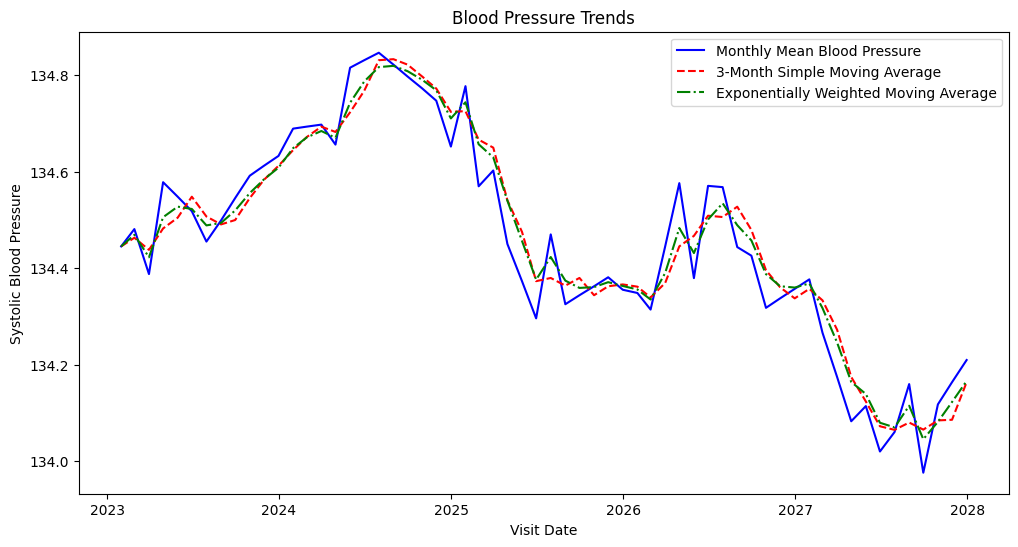

In [21]:
# Visualize the trends
plt.figure(figsize=(12, 6))
plt.plot(monthly_bp, label='Monthly Mean Blood Pressure', color='blue')
plt.plot(monthly_bp_smooth, label='3-Month Simple Moving Average', color='red', linestyle='--')
plt.plot(monthly_bp_ewm, label='Exponentially Weighted Moving Average', color='green', linestyle='-.')
plt.xlabel('Visit Date')
plt.ylabel('Systolic Blood Pressure')
plt.title('Blood Pressure Trends')
plt.legend()
plt.show()

## Statistical Modeling Tasks

1. Analyze factors affecting baseline blood pressure:
   - Use statsmodels OLS to predict `bp_systolic`
   - Include `age`, `bmi`, `smoking`, and `diabetes` as predictors
   - Interpret the coefficients and their p-values
   - Assess model fit using R-squared and diagnostic plots
   - Tips:
     - Create feature matrix `X` with predictors and add constant term using `sm.add_constant()`
     - Use `sm.OLS(y, X).fit()` to fit the model
     - Use `summary()` to examine p-values and confidence intervals
     - Plot residuals vs fitted values and Q-Q plot
     - Consider robust standard errors with `HC3` covariance type

In [22]:
# Set the target variable and predictors
X = df[['age', 'bmi', 'smoking', 'diabetes']]
y = df['bp_systolic_baseline']

# Add constant term
X = sm.add_constant(X)

In [23]:
# Fit to OLS model
model = sm.OLS(y, X).fit()

In [24]:
# Print the summary
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     bp_systolic_baseline   R-squared:                       0.376
Model:                              OLS   Adj. R-squared:                  0.376
Method:                   Least Squares   F-statistic:                     9207.
Date:                  Mon, 04 Nov 2024   Prob (F-statistic):               0.00
Time:                          13:04:14   Log-Likelihood:            -2.2574e+05
No. Observations:                 61000   AIC:                         4.515e+05
Df Residuals:                     60995   BIC:                         4.515e+05
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.4929      0.255

**All variables show a statistically significant positive association with baseline blood pressure.**

In [25]:
# Assess model fit using R-squared
r_squared = model.rsquared
print(f"R-squared: {r_squared}")

R-squared: 0.3764688299706507


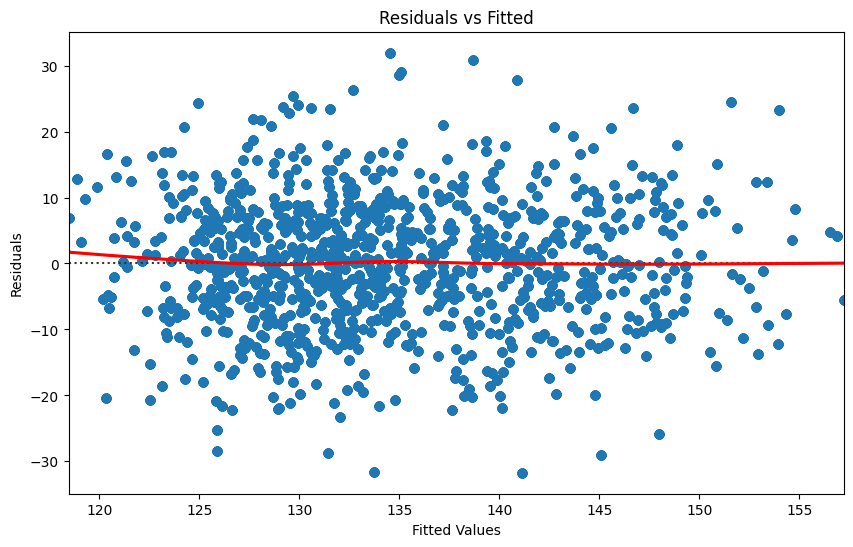

In [26]:
# Assess model fit using diagnostic plots -Residuals vs fitted values-
plt.figure(figsize=(10, 6))
sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True, line_kws={'color': 'red'})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()

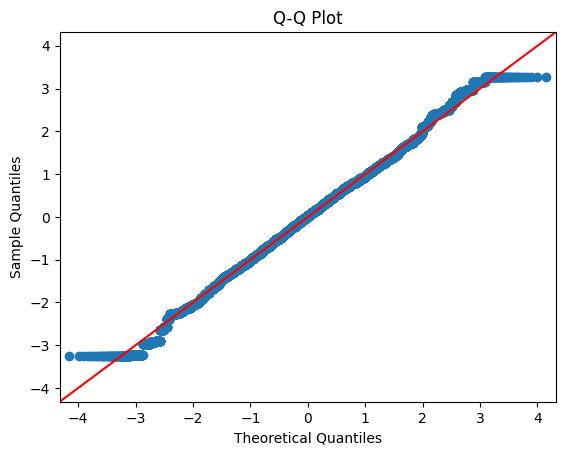

In [27]:
# Assess model fit using diagnostic plots - Q-Q Plot -
sm.qqplot(model.resid, line='45', fit=True)
plt.title('Q-Q Plot')
plt.show()

In [28]:
# Consider robust standard errors with `HC3` covariance type
HC3_model = model.get_robustcov_results(cov_type='HC3')

In [29]:
# Print the results
print(HC3_model.summary())

                             OLS Regression Results                             
Dep. Variable:     bp_systolic_baseline   R-squared:                       0.376
Model:                              OLS   Adj. R-squared:                  0.376
Method:                   Least Squares   F-statistic:                     9205.
Date:                  Mon, 04 Nov 2024   Prob (F-statistic):               0.00
Time:                          13:09:36   Log-Likelihood:            -2.2574e+05
No. Observations:                 61000   AIC:                         4.515e+05
Df Residuals:                     60995   BIC:                         4.515e+05
Df Model:                             4                                         
Covariance Type:                    HC3                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.4929      0.252

**Based on the diagnostic plots, the residuals appear random and follow a normal distribution, indicating that the OLS model fits the data well. Additionally, the results using HC3 robust standard errors are similar to the original OLS results, confirming the model's reliability even in the presence of potential heteroskedasticity.**

2. Model treatment effectiveness:
   - Fit a GLM with binomial family to predict treatment success
   - Use baseline characteristics and `adherence` as predictors
   - Report odds ratios and their confidence intervals
   - Assess model fit using deviance and diagnostic plots
   - Tips:
     - Create feature matrix `X` with predictors and add constant term
     - Use `sm.GLM(y, X, family=sm.families.Binomial()).fit()`
     - Get odds ratios with `np.exp(params)`
     - Check residual deviance vs null deviance
     - Use `influence()` to detect influential observations

In [30]:
# Set the target variable and predictors
X = df[['age', 'sex','bmi', 'smoking', 'diabetes','bp_systolic_baseline', 'cholesterol','heart_rate_baseline','adherence']]
y = df['outcome']

# Add the constant term
X = sm.add_constant(X)

In [34]:
# Fit to the GLM model
glm_mdl = sm.GLM(y, X, family=sm.families.Binomial()).fit()

In [35]:
# Print the summary
print(glm_mdl.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                61000
Model:                            GLM   Df Residuals:                    60990
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -39827.
Date:                Mon, 04 Nov 2024   Deviance:                       79655.
Time:                        13:21:21   Pearson chi2:                 6.10e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.02583
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -3.5227 

In [36]:
# Calculate the odds ratios and 95% CI
odds_ratios = np.exp(glm_mdl.params)
conf = np.exp(glm_mdl.conf_int())
print(f"Odds Ratios:\n{odds_ratios}\n")
print(f"95% Confidence Intervals:\n{conf}\n")

Odds Ratios:
const                   0.029521
age                     0.996469
sex                     0.892022
bmi                     1.026068
smoking                 0.597965
diabetes                0.564716
bp_systolic_baseline    1.008961
cholesterol             1.006952
heart_rate_baseline     1.001884
adherence               1.162271
dtype: float64

95% Confidence Intervals:
                             0         1
const                 0.021577  0.040389
age                   0.995100  0.997839
sex                   0.862838  0.922192
bmi                   1.022367  1.029781
smoking               0.566302  0.631399
diabetes              0.539243  0.591392
bp_systolic_baseline  1.007258  1.010667
cholesterol           1.006126  1.007779
heart_rate_baseline   1.000308  1.003462
adherence             0.982370  1.375117



**All variables except for adherence show a statistically significant association with the outcome. Age, being sex=1, smoking, and diabetes are associated with a reduced likelihood of the outcome, while higher BMI, baseline blood pressure, cholesterol, and baseline heart rate are associated with an increased likelihood of the outcome.**

In [37]:
# Assess model fit using deviance
print(f"Residual Deviance: {glm_mdl.deviance}")
print(f"Null Deviance: {glm_mdl.null_deviance}")

Residual Deviance: 79654.52375050817
Null Deviance: 81250.58592871984


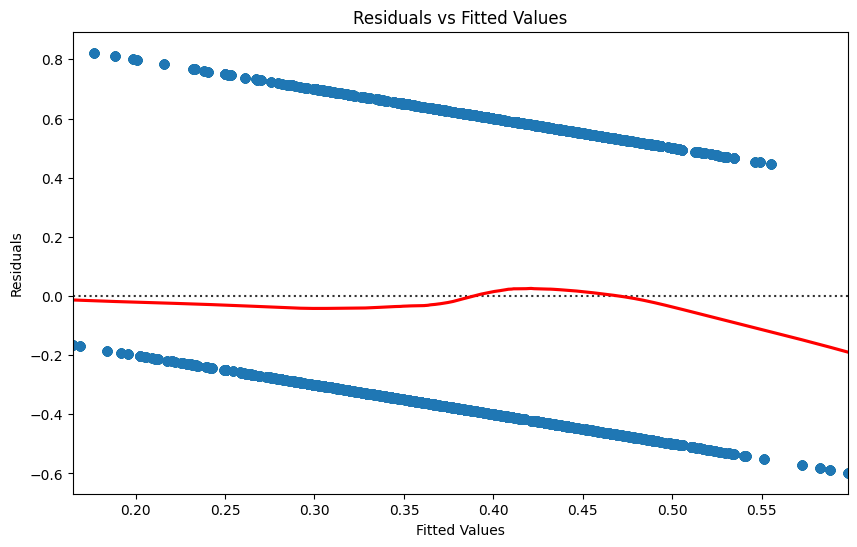

In [38]:
# Assess model fit using diagnostic plots -Residuals vs fitted values-
plt.figure(figsize=(10, 6))
sns.residplot(x=glm_mdl.fittedvalues, y=glm_mdl.resid_response, lowess=True, line_kws={'color': 'red'})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

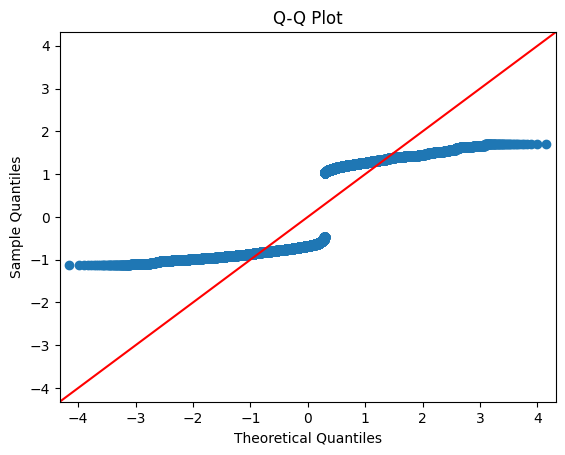

In [39]:
# Assess model fit using diagnostic plots - Q-Q Plot -
sm.qqplot(glm_mdl.resid_deviance, line='45', fit=True)
plt.title('Q-Q Plot')
plt.show()

In [40]:
# Detect influential observations
influence = glm_mdl.get_influence()
summary_frame = influence.summary_frame()

In [45]:
# Extract the data with the top five cooks distance
cooks = summary_frame.sort_values('cooks_d',ascending=False).head()

In [49]:
cooks

,dfb_const,dfb_age,dfb_sex,dfb_bmi,dfb_smoking,dfb_diabetes,dfb_bp_systolic_baseline,dfb_cholesterol,dfb_heart_rate_baseline,dfb_adherence,cooks_d,standard_resid,hat_diag,dffits_internal
visit_date,,,,,,,,,,,,,,
2025-08-26,-0.000894,-0.000897,0.003246,-0.000875,-0.000459,0.003663,-0.000366,-0.001497,0.000103,0.004951,0.000085,2.157595,0.000183,0.029197
2025-06-23,0.002551,0.000034,0.004355,-0.005760,0.001122,-0.005681,0.003705,-0.002134,-0.004447,-0.002085,0.000085,2.157595,0.000183,0.029197
2023-01-17,-0.002985,0.001130,0.004078,0.001540,-0.005267,-0.005157,0.001449,0.002351,0.003964,-0.002974,0.000085,2.157595,0.000183,0.029197
2027-09-17,-0.003791,0.001767,-0.004395,0.001787,-0.001959,-0.004135,0.003098,0.000804,0.000979,0.001246,0.000085,2.157595,0.000183,0.029197
2025-06-23,-0.000894,-0.000897,0.003246,-0.000875,-0.000459,0.003663,-0.000366,-0.001497,0.000103,0.004951,0.000085,2.157595,0.000183,0.029197


**Based on the diagnostic plots, the residuals does not appear random and follow a normal distribution, indicating that the glm model does not fit the data well.**

**The largest Cook's Distance is 0.0018, which is well below the threshold of 0.5. This suggests that the impact of outliers on the model is likely minimal.**

## Machine Learning Tasks (stretch goal)

1. Build a prediction pipeline:
   - Create features from baseline characteristics
   - Standardize numeric features using `StandardScaler`
   - Train a logistic regression model to predict treatment outcomes
   - Include regularization to prevent overfitting
   - Tips:
     ```python
     from sklearn.pipeline import make_pipeline
     from sklearn.preprocessing import StandardScaler
     from sklearn.linear_model import LogisticRegression
     
     # Create pipeline with specific components
     pipeline = make_pipeline(
         StandardScaler(),
         LogisticRegression(
             penalty='l2',
             solver='lbfgs',
             max_iter=1000,
             class_weight='balanced'
         )
     )
     ```
     - Use `ColumnTransformer` for mixed numeric/categorical features
     - Consider `SelectKBest` or `RFE` for feature selection
     - Try different regularization strengths with `C` parameter
     - Use `Pipeline` to prevent data leakage

In [54]:
# Set the target variable and predictors
X = df[['age','sex','bmi','smoking', 'diabetes','bp_systolic_baseline','cholesterol','heart_rate_baseline','adherence']]
y = df['outcome']

In [55]:
# Split the data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [56]:
# Create the pipeline
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        penalty='l2',  # L2 norm
        solver='lbfgs',
        max_iter=1000,
        class_weight='balanced',  # Handle the imbalanced data
    )
)

In [57]:
# Fit to the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [59]:
# Predict the values using test data
y_pred = pipeline.predict(X_test)

In [60]:
# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.56      0.62     11273
           1       0.47      0.63      0.54      7027

    accuracy                           0.58     18300
   macro avg       0.59      0.59      0.58     18300
weighted avg       0.61      0.58      0.59     18300

[[6297 4976]
 [2628 4399]]


2. Validate model performance:
   - Split data into 70% training and 30% test sets
   - Implement 5-fold cross-validation on the training set
   - Report accuracy, precision, recall, and ROC AUC
   - Generate confusion matrix and ROC curve
   - Tips:
     ```python
     from sklearn.model_selection import (
         train_test_split, 
         StratifiedKFold,
         cross_validate
     )
     from sklearn.metrics import (
         classification_report,
         RocCurveDisplay,
         confusion_matrix
     )
     
     # Stratified split for imbalanced data
     X_train, X_test, y_train, y_test = train_test_split(
         X, y, 
         test_size=0.3, 
         stratify=y,
         random_state=42
     )
     
     # Cross-validation with multiple metrics
     cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
     scores = cross_validate(
         pipeline,
         X_train, y_train,
         cv=cv,
         scoring=['accuracy', 'precision', 'recall', 'roc_auc']
     )
     ```
     - Use `StratifiedKFold` for imbalanced datasets
     - Consider precision-recall curve for imbalanced data
     - Plot learning curves to diagnose bias/variance
     - Use `cross_validate` for multiple metrics at once


In [77]:
# Stratified split for imbalanced data to train and test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [78]:
# Five fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_validate(
    pipeline,
    X_train, y_train,
    cv=cv,
    scoring=['accuracy', 'precision', 'recall', 'roc_auc'],
    return_train_score=True
)

In [82]:
# scores
print(f'Cross-Validated Accuracy: {np.mean(scores['test_accuracy']):.2f}')
print(f'Cross-Validated Precision: {np.mean(scores['test_precision']):.2f}')
print(f'Cross-Validated Recall: {np.mean(scores['test_recall']):.2f}')
print(f'Cross-Validated ROC AUC: {np.mean(scores['test_roc_auc']):.2f}')

Cross-Validated Accuracy: 0.58
Cross-Validated Precision: 0.46
Cross-Validated Recall: 0.61
Cross-Validated ROC AUC: 0.60


In [80]:
# Evaluate the model using the test data
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [81]:
# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.71      0.56      0.62     11273
           1       0.47      0.63      0.54      7027

    accuracy                           0.58     18300
   macro avg       0.59      0.59      0.58     18300
weighted avg       0.61      0.58      0.59     18300

[[6297 4976]
 [2628 4399]]


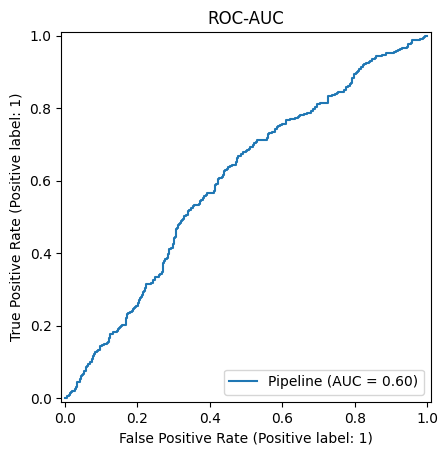

In [76]:
# ROC Curve
RocCurveDisplay.from_estimator(pipeline, X_test, y_test)
plt.title('ROC-AUC')
plt.show()

Cross-Validated Accuracy: 0.58
Cross-Validated Precision: 0.46
Cross-Validated Recall: 0.61
Cross-Validated ROC AUC: 0.60
This model does not predict the outcomes well beacuse all scores are less than 0.8. However, the cross-validated scores are close to the test results, indicating that cross-validation is an effective method for preventing overfitting.